# Correction for bbp


- Bbp computation from beta
- Positive value [global range]
- High deep value
- Stuck value
- Noisy profile
- Spike detection
- Surface bubbles
  
****


## Import libraries and datasets

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glidertools as gt
from pathlib import Path
import os

# Define paths
path = Path(os.getcwd())
scripts = path.parent.absolute()
project = scripts.parent.absolute()
data = os.path.join(project, 'Data')

# Load your glider data
ds = xr.open_dataset(os.path.join(data, 'Gliders/NRT/Doombar_648_Profiled.nc'))

## bbp from beta

In [ ]:
#I etract bbp, profile number and depth as 1D arrays to ease processing with glidertools functions.
#If there is a neater way of doing this, please let me know!
bbp_1d = np.array(ds['BBP700']) #It is called BBP700 in the file but it actually is beta
prof_1d = np.array(ds['PROFILE_NUMBER'])
depth_1d = np.array(ds['DEPTH'])


In [ ]:
#The two following parameters are sensor specific and should be defined by user in the config file. The provided values here are probably the most common ones.
theta = 124
xfactor = 1.076

bbp_corrected = gt.flo_functions.flo_bback_total(bbp_1d, ds['TEMP'].data, ds['PRAC_SALINITY'].data, theta, 700, xfactor)



c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [ ]:
def plot_bbp_boxplot(beta_data, bbp_data, title):
    """
    Plot boxplots for beta and bbp_corrected after removing NaNs and outliers.

    Outliers are defined using the 1.5 * IQR rule.
    """

    def remove_outliers(data):
        data = np.array(data)
        data = data[np.isfinite(data)]  # remove NaNs
        if len(data) == 0:
            return data
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        return data[(data >= lower) & (data <= upper)]

    # Clean both datasets
    beta_clean = remove_outliers(beta_data)
    bbp_clean = remove_outliers(bbp_data)

    print(f"Beta valid after cleaning: {len(beta_clean)}")
    print(f"BBp valid after cleaning: {len(bbp_clean)}")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.boxplot([beta_clean, bbp_clean],
                vert=True, patch_artist=True,
                labels=['Beta', 'BBp'])

    plt.title(title)
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Beta valid after cleaning: 774994
BBp valid after cleaning: 8273


C:\Users\flapet\AppData\Local\Temp\ipykernel_36512\3830659887.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([beta_clean, bbp_clean],


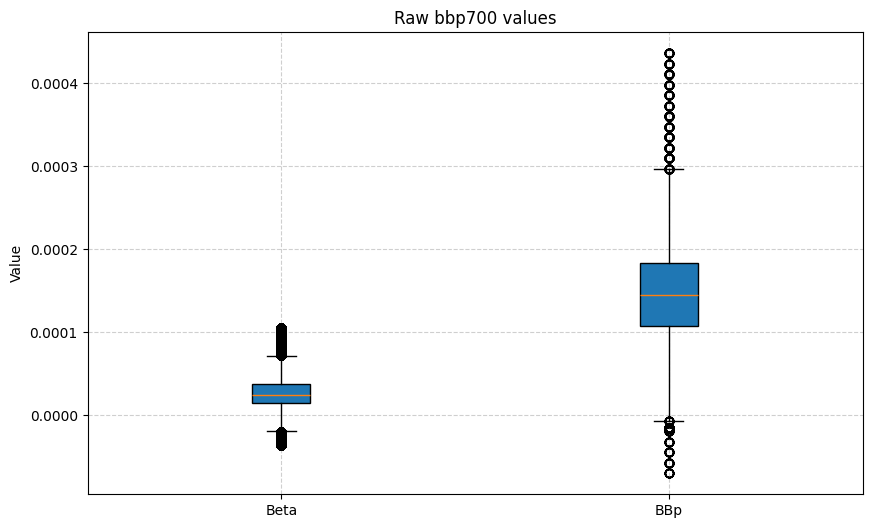

In [26]:
plot_bbp_boxplot(bbp_1d, bbp_corrected, 'Raw bbp700 values')

****

## Positive value [global range]

In [27]:
def remove_negative_values(data):
    """
    Remove negative values from the dataset.
    """
    data = np.array(data)
    return data[data >= 0]

In [28]:
bbp_corrected = remove_negative_values(bbp_corrected)

****

## Spike detection

In [29]:
bbp_baseline, bbp_spikes = gt.cleaning.despike(bbp_corrected, 7, spike_method='minmax')

c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [31]:
ds["BBP700_ADJUSTED"] = xr.DataArray(bbp_baseline, coords=ds["BBP700"].coords, dims=ds["BBP700"].dims,
                                     attrs=ds["BBP700"].attrs)

ds["BBP700_ADJUSTED"].attrs['long_name'] = 'Corrected particulate backscattering coefficient at 700 nm'
ds["BBP700_ADJUSTED"].attrs['standard_name'] = 'bbp700_adjusted'
ds["BBP700_ADJUSTED"].attrs['comments'] = 'Corrected for temperature and salinity effects, negative values removed, despiked using minmax method with a window size of 7'#TODO interact with config file for window size and method

AlignmentError: cannot reindex or align along dimension 'N_MEASUREMENTS' because of conflicting dimension sizes: {9077, 1996165}